In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from math import pi
import datetime as dt
import plotly.express as px


In [2]:

df = pd.read_excel("Online Retail.xlsx")


print(df.columns.tolist())
df.head()


['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:

df.dropna(inplace=True)


df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]


df['TotalPrice'] = df['Quantity'] * df['Price']


In [4]:

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)


rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()


rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,165,11,372.86
1,12347.0,3,2,1323.32
2,12348.0,74,1,222.16
3,12349.0,43,3,2671.14
4,12351.0,11,1,300.93


In [5]:

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


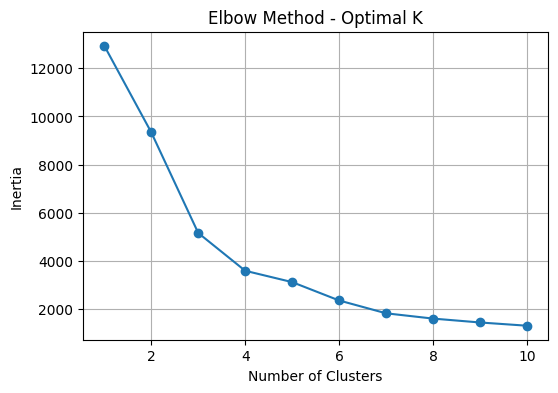

In [6]:
inertia = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    inertia.append(model.inertia_)

# Plot the elbow curve
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method - Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


In [7]:

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(1)


,Recency,Frequency,Monetary
Cluster,,,
0,43.0,4.5,1743.1
1,243.0,1.7,596.9
2,5.6,113.6,215543.7
3,15.4,48.5,29040.2


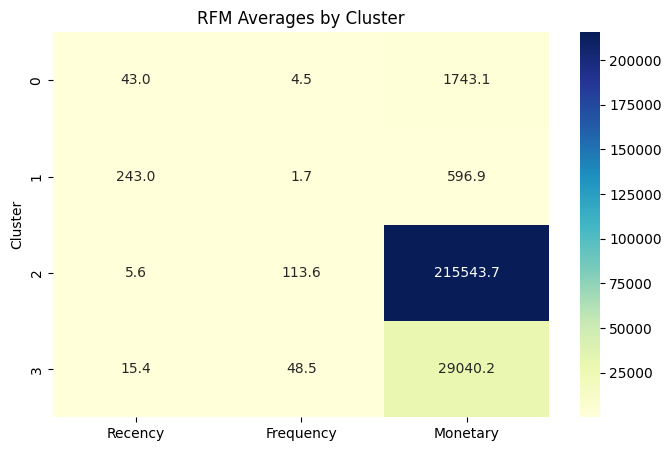

In [8]:
plt.figure(figsize=(8, 5))
sns.heatmap(rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean(),
            annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("RFM Averages by Cluster")
plt.show()


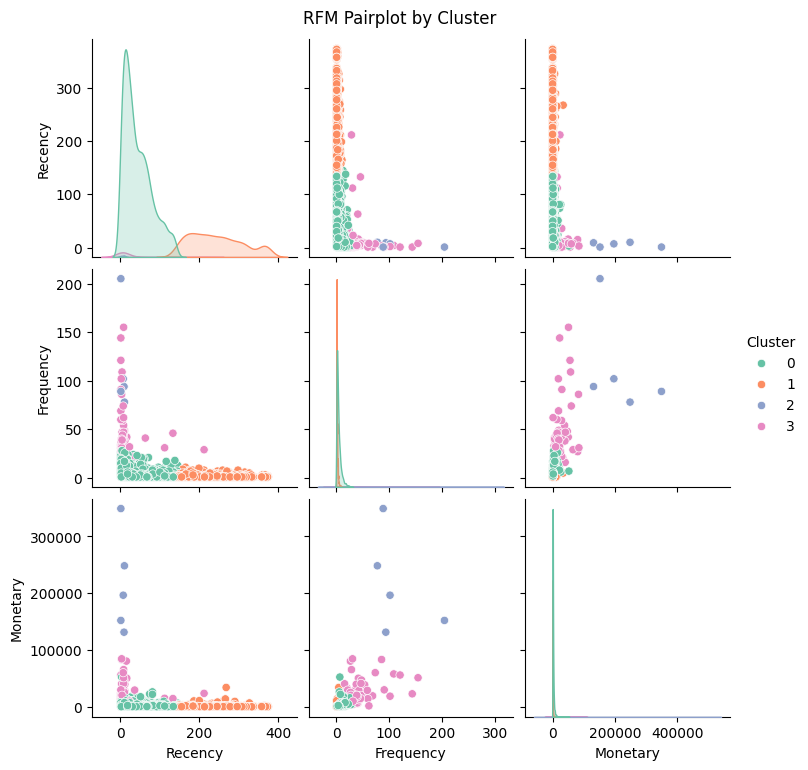

In [9]:
sns.pairplot(rfm, vars=['Recency', 'Frequency', 'Monetary'], hue='Cluster', palette='Set2')
plt.suptitle("RFM Pairplot by Cluster", y=1.02)
plt.show()


C:\Users\bisht\AppData\Local\Temp\ipykernel_5984\1596003532.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Cluster', palette='Set3')


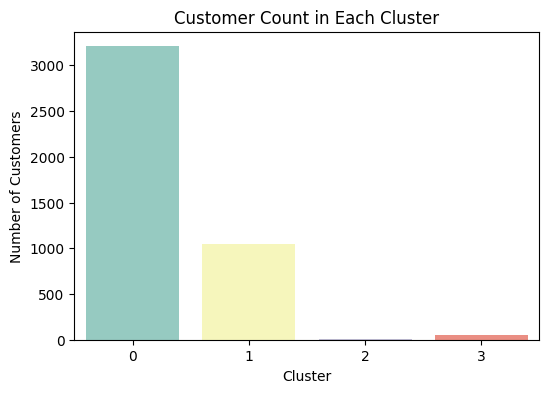

In [10]:
plt.figure(figsize=(6, 4))
sns.countplot(data=rfm, x='Cluster', palette='Set3')
plt.title("Customer Count in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()


C:\Users\bisht\AppData\Local\Temp\ipykernel_5984\2747796396.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Recency', data=rfm, ax=axes[0], palette='coolwarm')
C:\Users\bisht\AppData\Local\Temp\ipykernel_5984\2747796396.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Frequency', data=rfm, ax=axes[1], palette='crest')
C:\Users\bisht\AppData\Local\Temp\ipykernel_5984\2747796396.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Monetary', data=rfm, ax=axes[2], palette='flare')


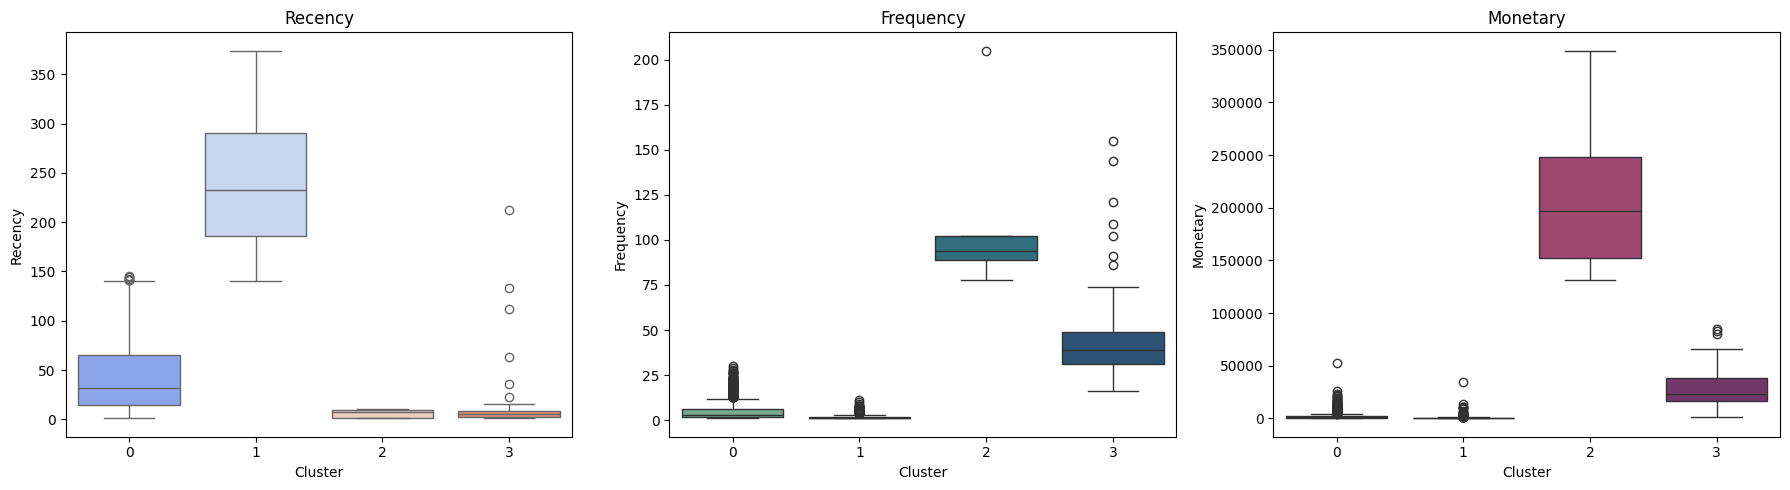

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='Cluster', y='Recency', data=rfm, ax=axes[0], palette='coolwarm')
axes[0].set_title("Recency")

sns.boxplot(x='Cluster', y='Frequency', data=rfm, ax=axes[1], palette='crest')
axes[1].set_title("Frequency")

sns.boxplot(x='Cluster', y='Monetary', data=rfm, ax=axes[2], palette='flare')
axes[2].set_title("Monetary")

plt.tight_layout()
plt.show()


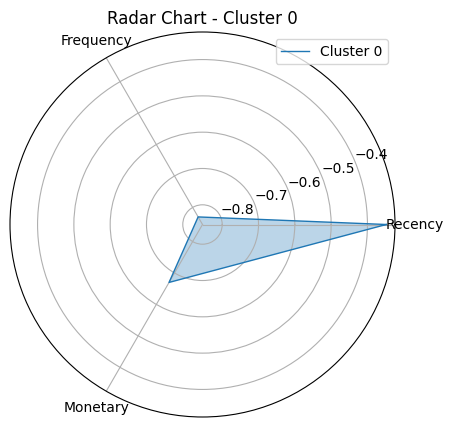

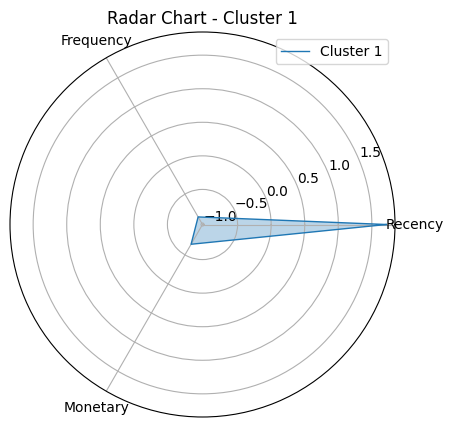

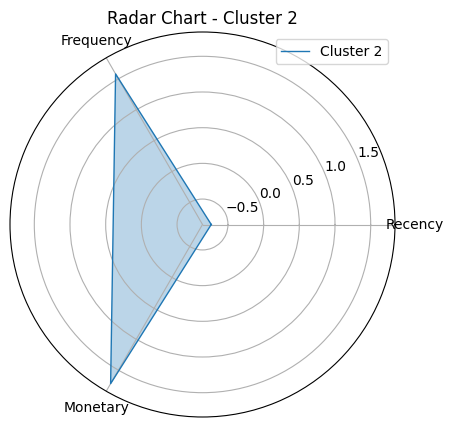

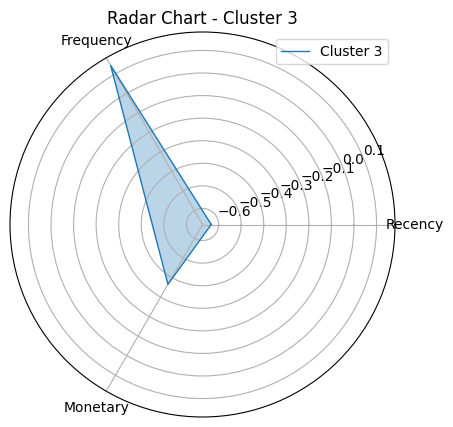

In [12]:

cluster_rfm = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
cluster_rfm_scaled = pd.DataFrame(StandardScaler().fit_transform(cluster_rfm), 
                                  columns=cluster_rfm.columns)
cluster_rfm_scaled['Cluster'] = cluster_rfm.index

categories = ['Recency', 'Frequency', 'Monetary']
N = len(categories)

for i in range(len(cluster_rfm_scaled)):
    values = cluster_rfm_scaled.loc[i, categories].tolist()
    values += values[:1]
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    plt.figure(figsize=(5, 5))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories)
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.3)
    plt.title(f"Radar Chart - Cluster {i}")
    plt.legend(loc='upper right')
    plt.show()


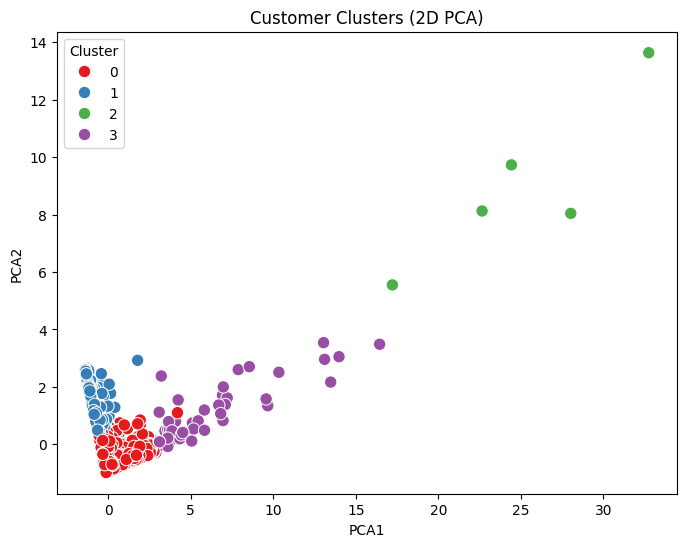

In [13]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = pca_result[:, 0]
rfm['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=rfm, palette='Set1', s=80)
plt.title("Customer Clusters (2D PCA)")
plt.show()


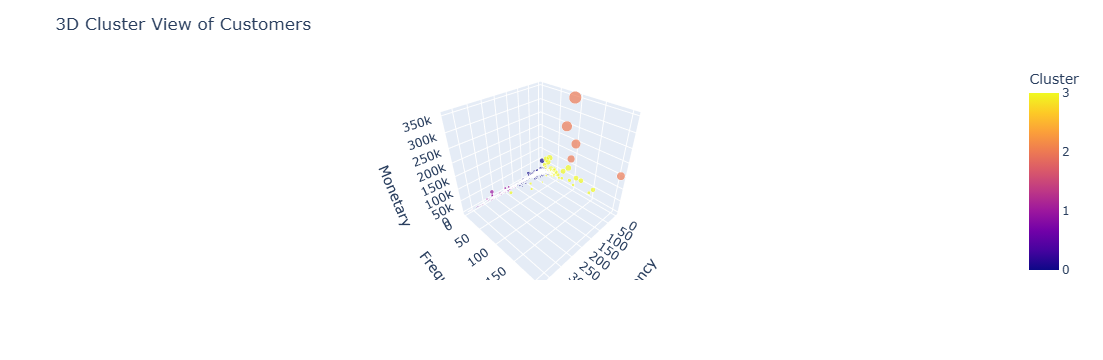

In [14]:
fig = px.scatter_3d(rfm, x='Recency', y='Frequency', z='Monetary',
                    color='Cluster', size='Monetary', hover_data=['CustomerID'])
fig.update_layout(title='3D Cluster View of Customers')
fig.show()
